In [1]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.data.core import *
from fastai2.distributed import *
from fastai2.data.transforms import *


In [2]:
from reformer_pytorch import Reformer, ReformerLM
from itertools import product

In [3]:
#import numpy as np
import random
#from tqdm import tqdm
import gc
from sklearn.model_selection import GroupKFold
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)



In [4]:
# configurations and main hyperparammeters
SEGMENT_SIZE = 100000 # 500000
WINDOW_SIZE = 400
BS = 3*12
SPLITS = 5

assert SEGMENT_SIZE % WINDOW_SIZE == 0
assert (SEGMENT_SIZE // WINDOW_SIZE) % SPLITS == 0
SEED = 321
DATA_SUFFIX = '_clean'

p_input = Path('input')

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [5]:
# read data
train_dtypes = {'time': np.float32, 'signal': np.float32, 'open_channels': np.int32 }
test_dtypes  = {'time': np.float32, 'signal': np.float32 }
df_train  = pd.read_csv(p_input / f'train.csv', dtype= train_dtypes)
df_test   = pd.read_csv(p_input / f'test.csv',  dtype= test_dtypes)
df_train_drift = pd.read_csv(p_input / f'train{DATA_SUFFIX}.csv', dtype= train_dtypes)
df_test_drift  = pd.read_csv(p_input / f'test{DATA_SUFFIX}.csv',  dtype= test_dtypes)
sub   = pd.read_csv(p_input / 'sample_submission.csv',  dtype={'time': np.float32})
df_train['drift'] = df_train['signal'] - df_train_drift['signal']
df_test['drift']  = df_test['signal']  - df_test_drift['signal']

In [6]:
df_train['signal'] =  df_train_drift['signal']
df_test['signal']  =   df_test_drift['signal']

In [7]:
len(df_train),SEGMENT_SIZE

(5000000, 100000)

In [8]:
df_train['open_channels'][2300000:2400000][(df_train['open_channels'][2300000:2400000]==0)]=1

In [9]:
d_xtra_csvs = {
    1: ['outfinaltest10.csv',  'outfinaltest44.csv',],#  'outfinaltest78.csv',],  'outfinaltest10.csv',  'outfinaltest44.csv'],
    3: ['outfinaltest1.csv',   'outfinaltest2.csv',   'outfinaltest3.csv',   'outfinaltest4.csv', 'outfinaltest5.csv'],
    5: ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv',]#, 'outfinaltest328.csv', 'outfinaltest534.csv']
}

df_train_xtra = None
for _,xtra_csvs in d_xtra_csvs.items():
    print(_,xtra_csvs)
    for xtra_csv in xtra_csvs:
        xx = pd.read_csv(p_input / xtra_csv , header=None,names=['time', 'signal', 'open_channels'])
        df_train_xtra = pd.concat((xx,df_train_xtra), axis=0)
df_train_xtra['drift']  = 0.
#df_train = pd.concat((df_train,df_train_xtra), axis=0)

1 ['outfinaltest10.csv', 'outfinaltest44.csv']
3 ['outfinaltest1.csv', 'outfinaltest2.csv', 'outfinaltest3.csv', 'outfinaltest4.csv', 'outfinaltest5.csv']
5 ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv']


In [10]:
train = torch.cat((torch.FloatTensor(df_train['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['drift'         ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['open_channels' ].values).unsqueeze(0)))
test  = torch.cat((torch.FloatTensor(df_test ['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_test ['drift'         ].values).unsqueeze(0)))
signal = torch.cat((train[0],test[0]))
signal_mean, signal_std = signal.mean(),signal.std()
train[0] = (train[0] - signal_mean) / signal_std
test[0]  = ( test[0] - signal_mean) / signal_std
train = train.view(train.shape[0],-1,SEGMENT_SIZE)
test  =  test.view( test.shape[0],-1,SEGMENT_SIZE)

In [11]:
train_channels_in_segment=[]
for s in range(0,len(df_train),SEGMENT_SIZE):
    channels = LongTensor(df_train['open_channels'][s:s+SEGMENT_SIZE].unique())
    channels_hot = torch.zeros(11,11)
    channels_hot = channels_hot.scatter(0,channels.unsqueeze(0), 1.).sum(dim=1)
    train_channels_in_segment.append(channels_hot)
train_channels_in_segment
assert len(train_channels_in_segment)*SEGMENT_SIZE == train.shape[1]*train.shape[2]

In [12]:
test_channels_in_segment = FloatTensor([
    [1,1,0,0,0,0,0,0,0,0,0], # A
    [1,1,1,1,0,0,0,0,0,0,0], # B
    [0,1,1,1,1,1,0,0,0,0,0], # C
    [1,1,0,0,0,0,0,0,0,0,0], # D
    [1,1,0,0,0,0,0,0,0,0,0], # E
    [0,0,0,0,1,1,1,1,1,1,1], # F
    [1,1,1,1,1,1,0,0,0,0,0], # G
    [0,0,0,0,1,1,1,1,1,1,1], # H
    [1,1,0,0,0,0,0,0,0,0,0], # I
    [1,1,1,1,0,0,0,0,0,0,0], # J
    [1,1,0,0,0,0,0,0,0,0,0], # 
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
])
test_channels_in_segment = test_channels_in_segment.unsqueeze(0).repeat(100000//SEGMENT_SIZE,1,1).transpose(0,1).reshape(-1,11)
assert test_channels_in_segment.shape[0]*SEGMENT_SIZE == test.shape[1]*test.shape[2]
test_channels_in_segment.shape

torch.Size([20, 11])

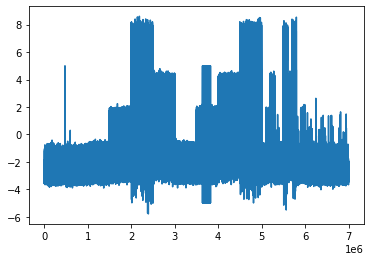

In [13]:
plt.plot(signal)

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 300
rcParams['agg.path.chunksize'] = 10000

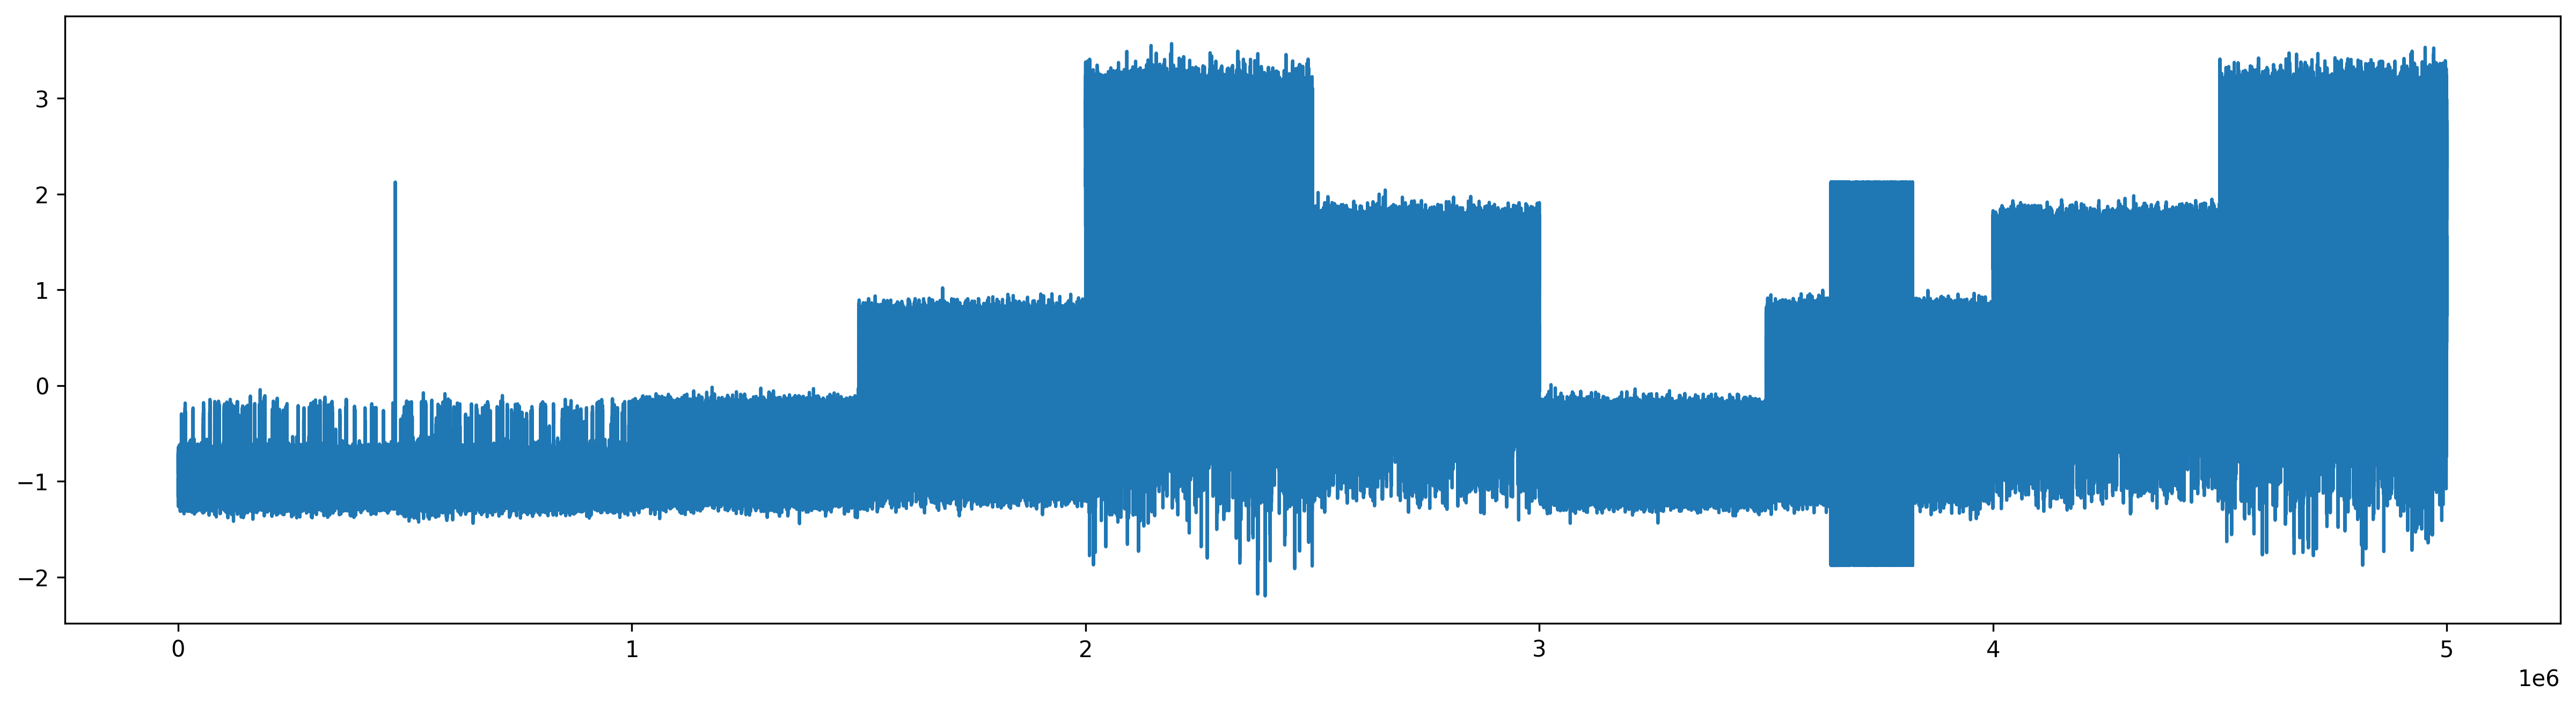

In [15]:
plt.plot(train[0].flatten())

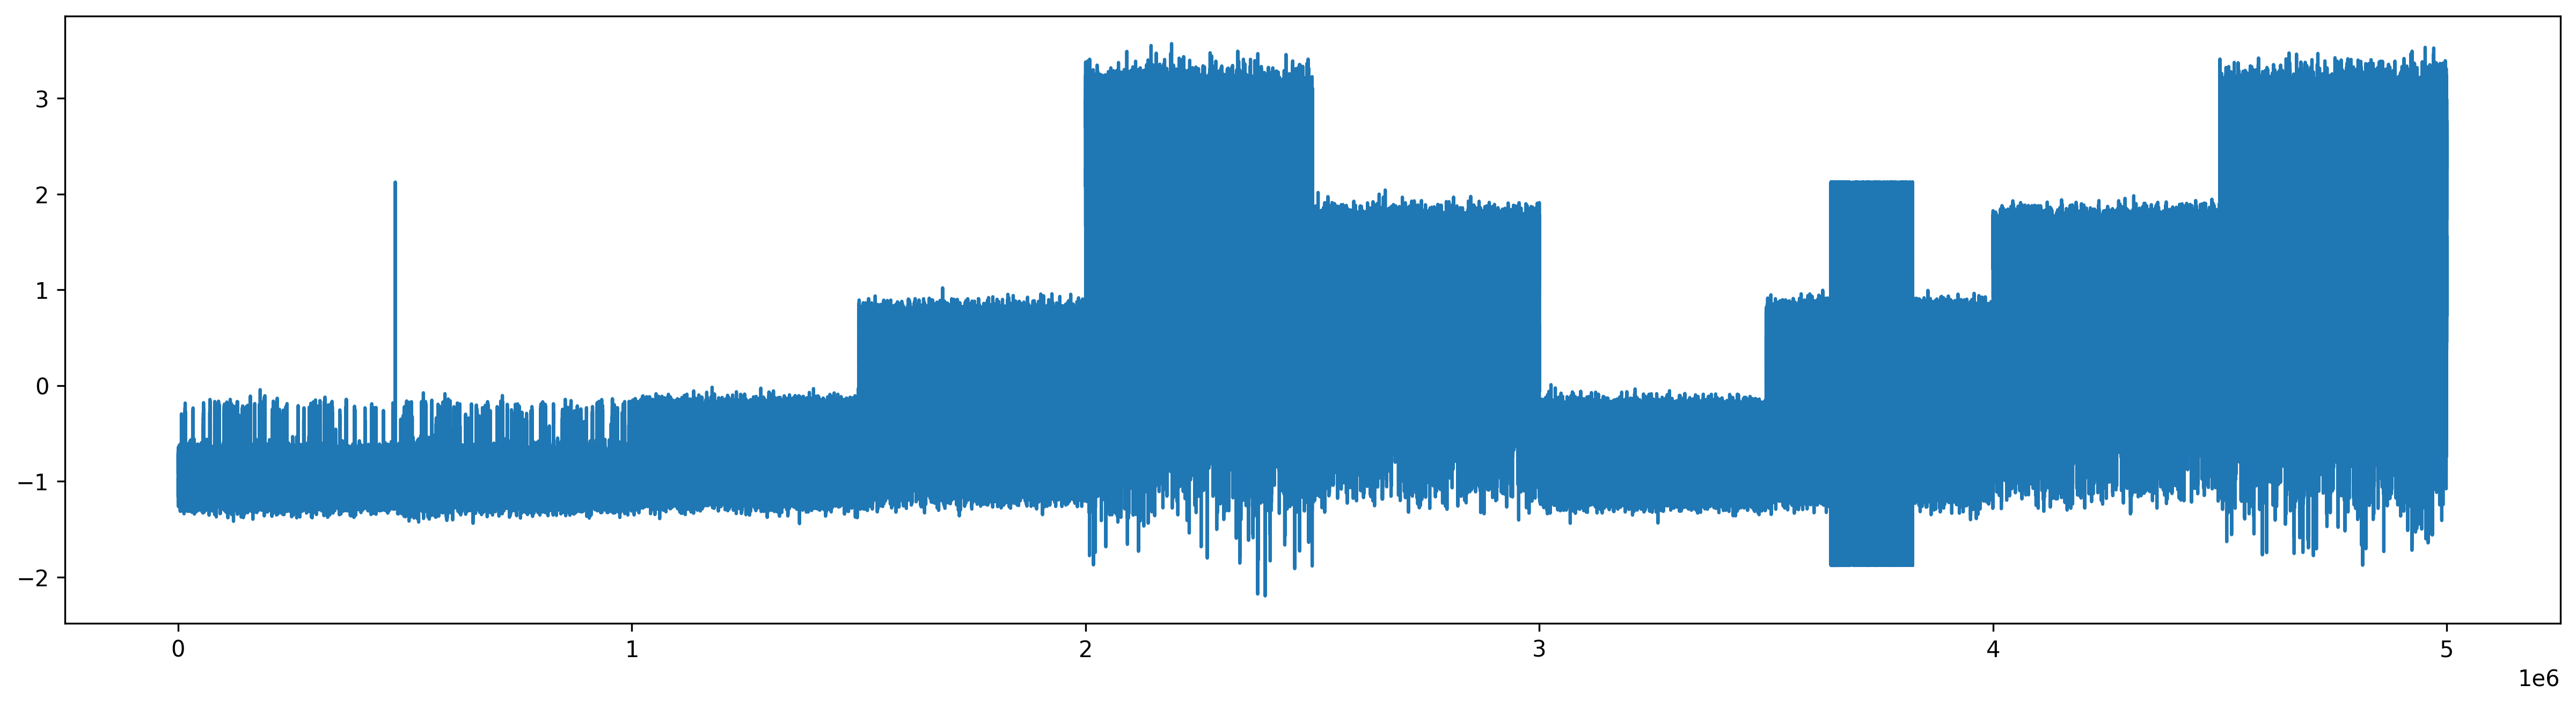

In [16]:
plt.plot(train[0].flatten())

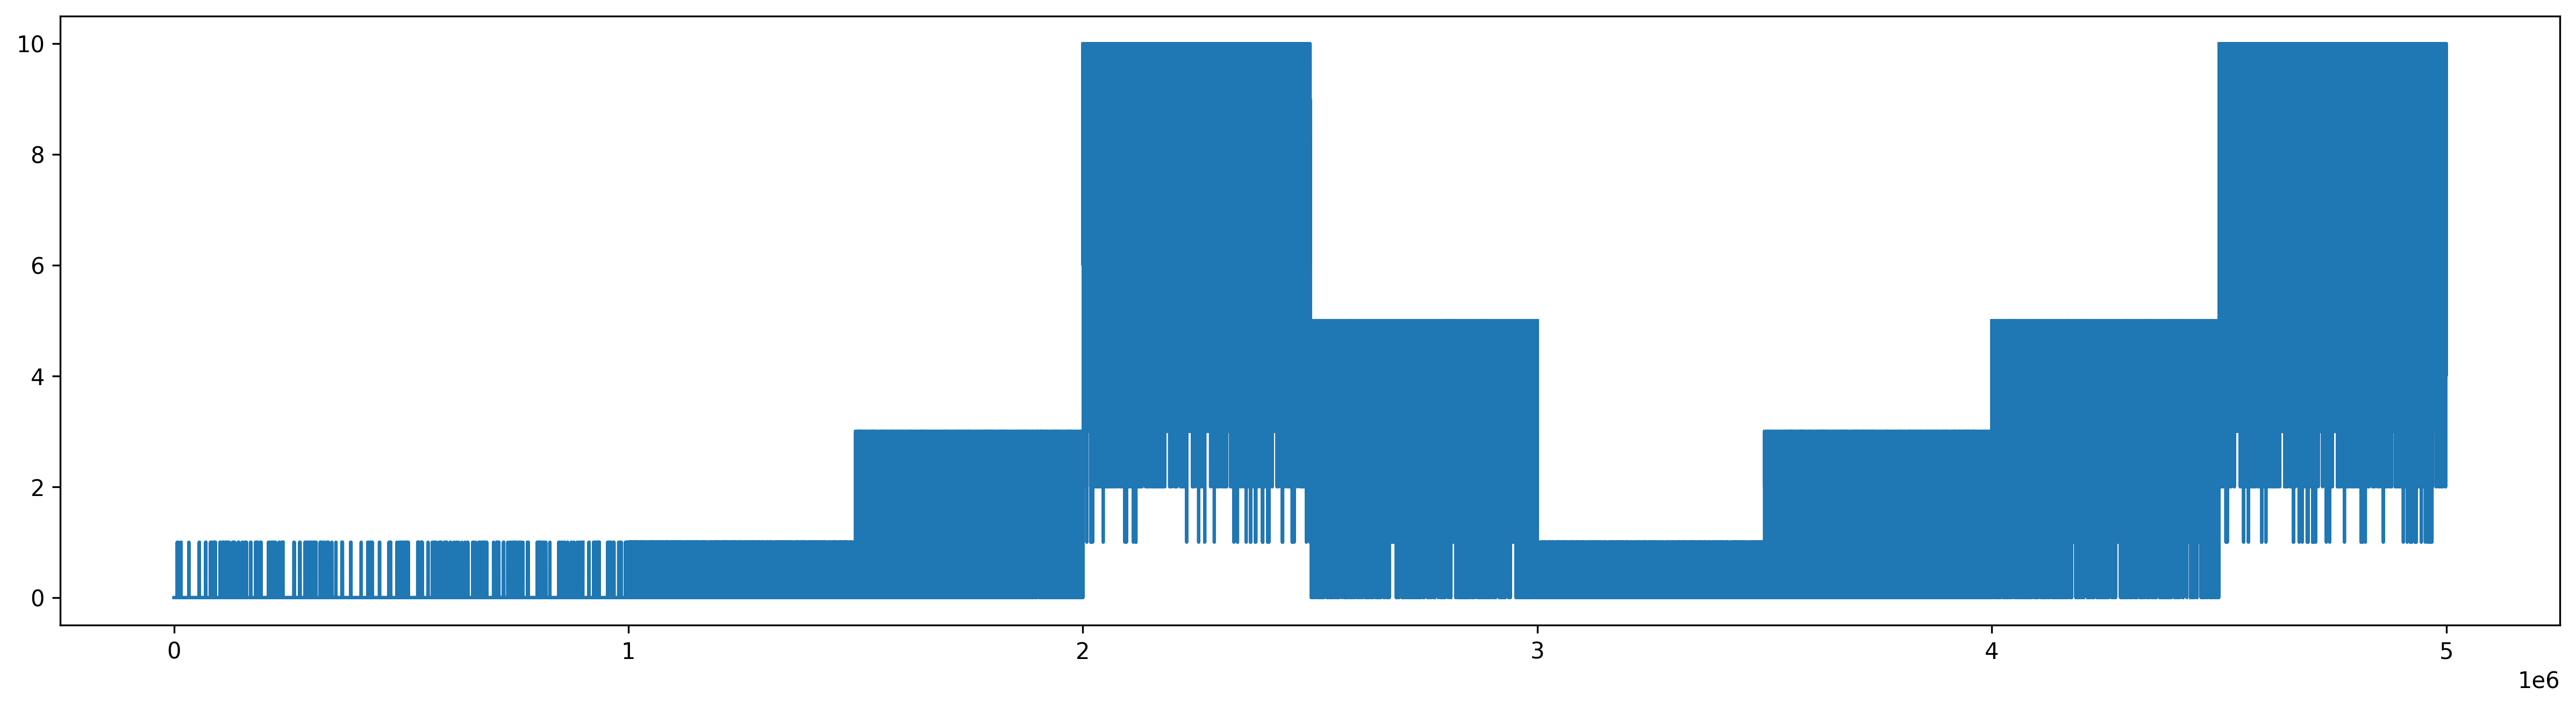

In [17]:
plt.plot(train[2].flatten())

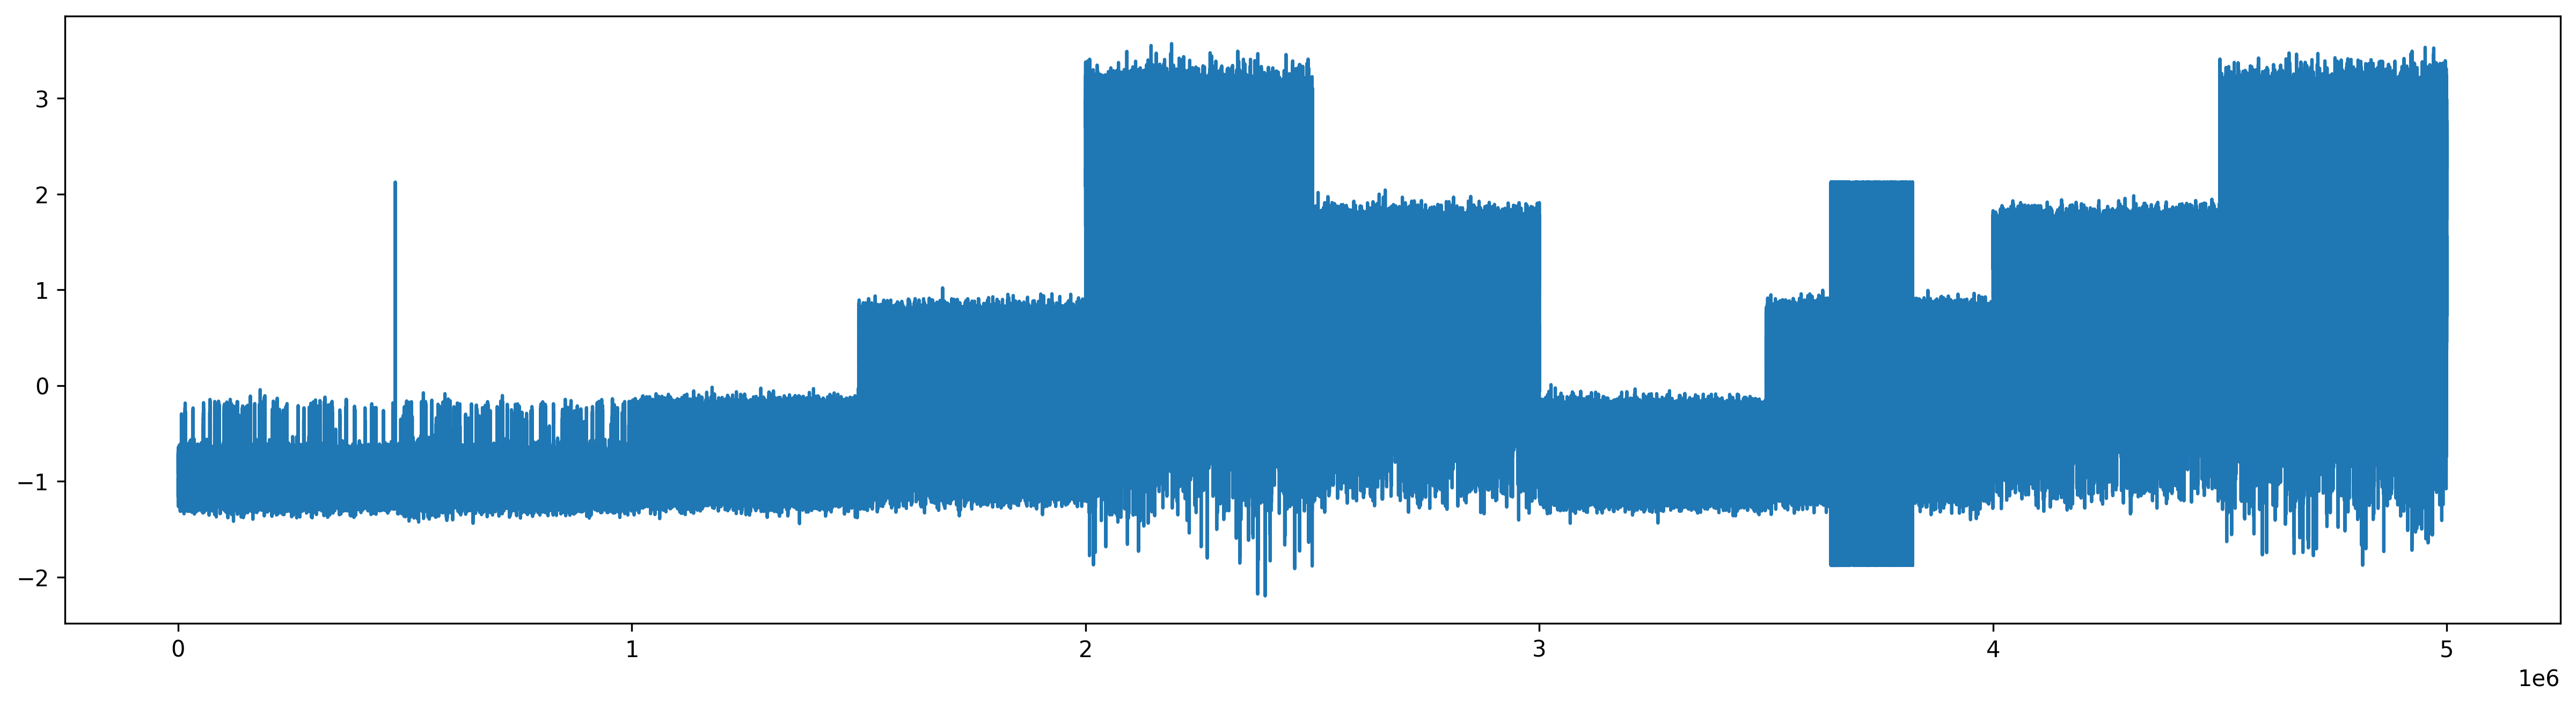

In [18]:
plt.plot(train[0,:].flatten())

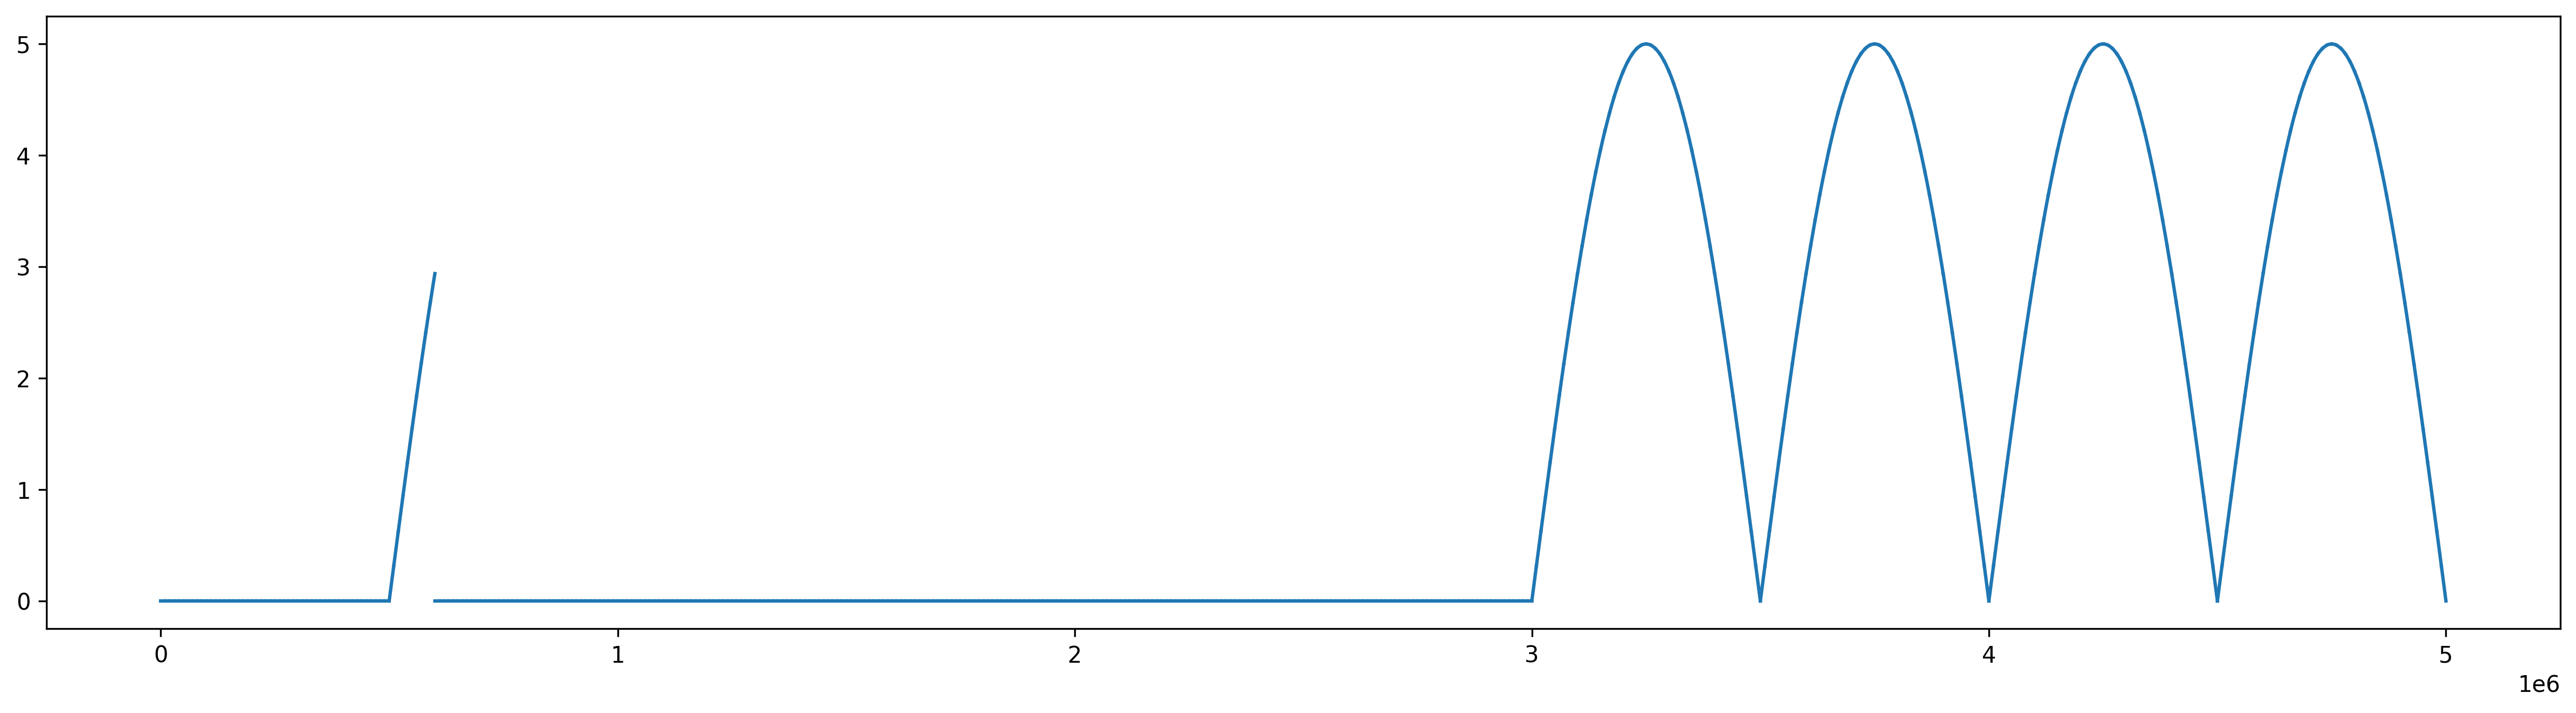

In [19]:
plt.plot(train[1,:].flatten())

In [20]:
split = 0
split_size = SEGMENT_SIZE//WINDOW_SIZE//SPLITS
valid_idx = split*split_size + np.arange(split_size)
train_idx = np.setdiff1d(np.arange(SEGMENT_SIZE//WINDOW_SIZE), valid_idx)
train_idx, valid_idx = list(product(range(train.shape[1]),train_idx)), list(product(range(train.shape[1]),valid_idx))
train_idx[:10],train_idx[10:]

([(0, 50),
  (0, 51),
  (0, 52),
  (0, 53),
  (0, 54),
  (0, 55),
  (0, 56),
  (0, 57),
  (0, 58),
  (0, 59)],
 [(0, 60),
  (0, 61),
  (0, 62),
  (0, 63),
  (0, 64),
  (0, 65),
  (0, 66),
  (0, 67),
  (0, 68),
  (0, 69),
  (0, 70),
  (0, 71),
  (0, 72),
  (0, 73),
  (0, 74),
  (0, 75),
  (0, 76),
  (0, 77),
  (0, 78),
  (0, 79),
  (0, 80),
  (0, 81),
  (0, 82),
  (0, 83),
  (0, 84),
  (0, 85),
  (0, 86),
  (0, 87),
  (0, 88),
  (0, 89),
  (0, 90),
  (0, 91),
  (0, 92),
  (0, 93),
  (0, 94),
  (0, 95),
  (0, 96),
  (0, 97),
  (0, 98),
  (0, 99),
  (0, 100),
  (0, 101),
  (0, 102),
  (0, 103),
  (0, 104),
  (0, 105),
  (0, 106),
  (0, 107),
  (0, 108),
  (0, 109),
  (0, 110),
  (0, 111),
  (0, 112),
  (0, 113),
  (0, 114),
  (0, 115),
  (0, 116),
  (0, 117),
  (0, 118),
  (0, 119),
  (0, 120),
  (0, 121),
  (0, 122),
  (0, 123),
  (0, 124),
  (0, 125),
  (0, 126),
  (0, 127),
  (0, 128),
  (0, 129),
  (0, 130),
  (0, 131),
  (0, 132),
  (0, 133),
  (0, 134),
  (0, 135),
  (0, 136),
  (0,

In [21]:
#train_idx = np.arange(SEGMENT_SIZE//WINDOW_SIZE)
#valid_idx = train_idx
#train_idx, valid_idx = list(product(range(train.shape[1]),train_idx)), list(product(range(train.shape[1]),valid_idx))


(18, 50)

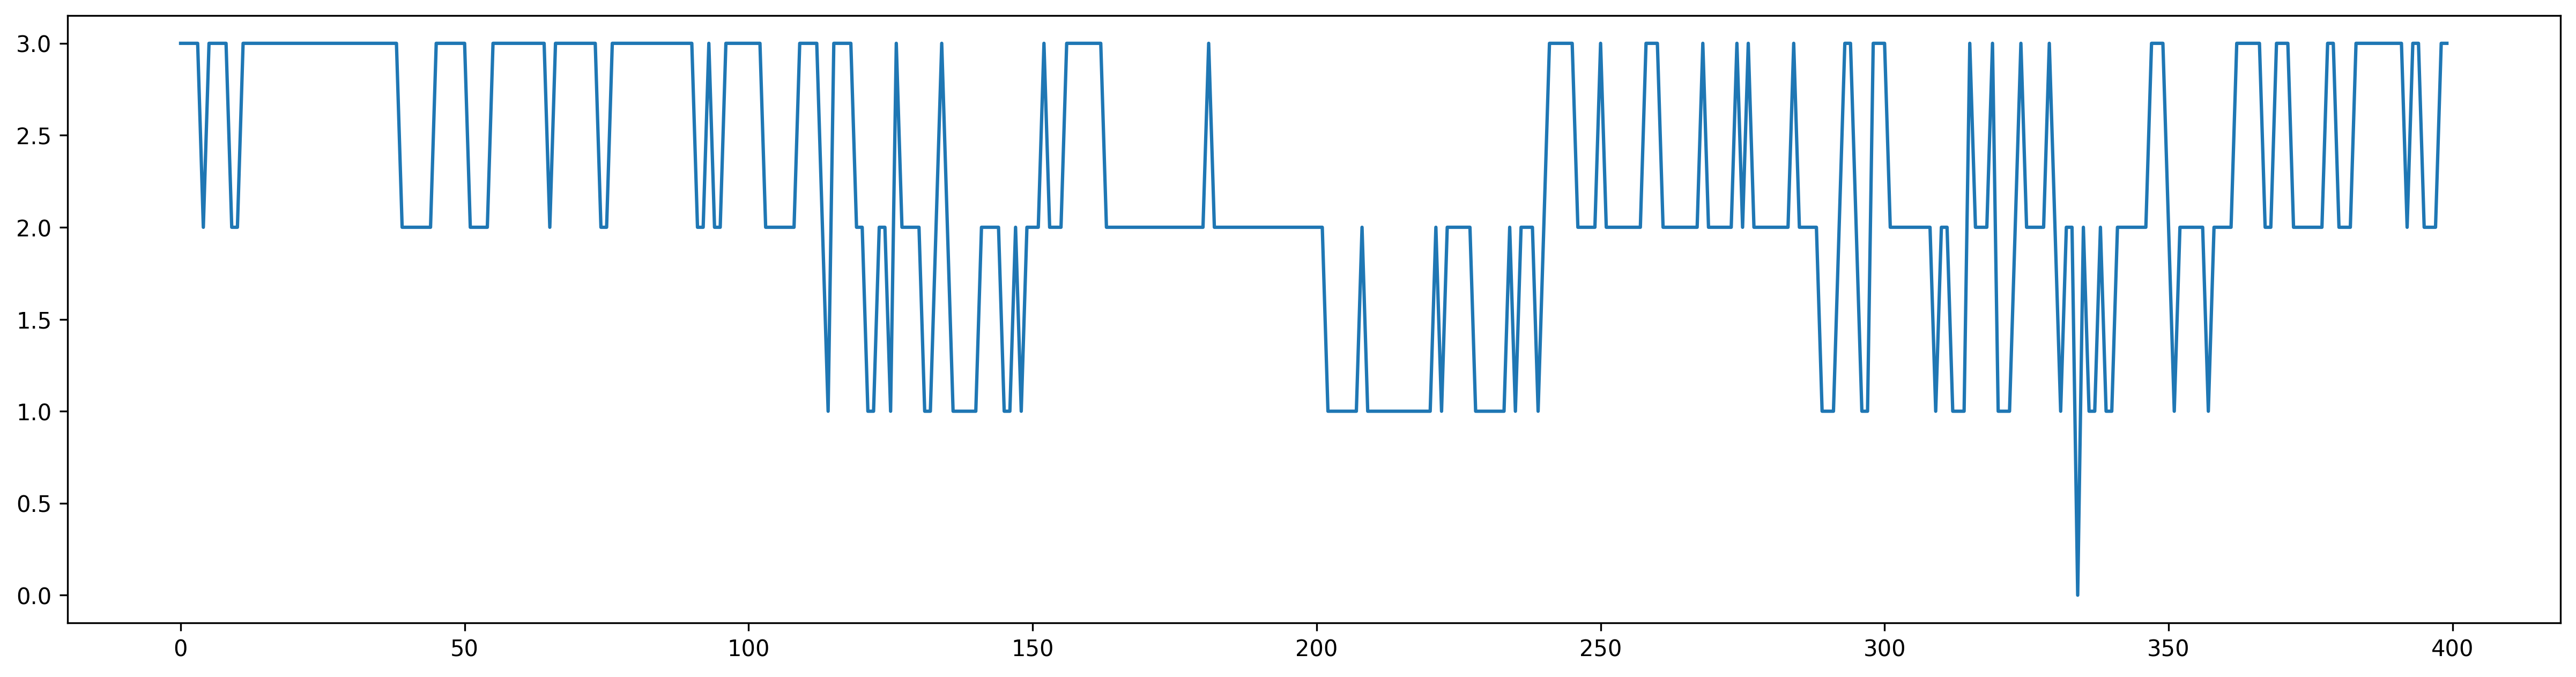

In [22]:
s,o=train_idx[400*9]
plt.plot(train[2,s,o*WINDOW_SIZE:(o+1)*WINDOW_SIZE])
s,o

In [23]:
def get_xy(t):
    print("Hey t")
class IonDataset(torch.utils.data.Dataset):
    def __init__(self, data,idx=None,jitter=False,p_flip=0.):
        super().__init__()
        self.data, self.channels_in_segment,self.jitter,self.p_flip = *data, jitter, p_flip
        self.idx = ifnone(idx,list(product(range(self.data.shape[1]),np.arange(SEGMENT_SIZE//WINDOW_SIZE))))
        self.n_inp = 1
        self.has_y = self.data.shape[0] == 3
    def __len__(self): return len(self.idx)
    def __getitem__(self, idx):
        s,o=self.idx[idx]
        jitter = 0
        if self.jitter:
            os,oe = 0,0
            if (s,(o-1)) in self.idx: os = -WINDOW_SIZE//2
            if (s,(o+1)) in self.idx: oe =  WINDOW_SIZE//2
            jitter = torch.randint(os,oe,(1,)).item()
        ss = slice(jitter+o*WINDOW_SIZE,jitter+(o+1)*WINDOW_SIZE)
        x =  self.data[0,s:s+1,ss]
        flip = (torch.rand(1) < self.p_flip).item()
        if flip: x=torch.flip(x,dims=(1,))
        x = (x,self.channels_in_segment[s])
        if self.has_y: 
            y_drift,y_open_channels = (self.data[1,s:s+1,ss], self.data[2,s:s+1,ss].long())
            if flip: y_drift,y_open_channels=(torch.flip(y_drift,dims=(1,)),torch.flip(y_open_channels,dims=(1,)))
            return (x,(y_drift,y_open_channels))
        return (x,)
    
train_ds = IonDataset((train, train_channels_in_segment), train_idx, jitter=True, p_flip=0.5)
valid_ds = IonDataset((train, train_channels_in_segment), valid_idx)
test_ds  = IonDataset((test,  test_channels_in_segment))
train_dl = DataLoader(train_ds, BS, shuffle=True,  num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, BS, shuffle=False, num_workers=4, pin_memory=True)
test_dl  = DataLoader(test_ds,  BS, shuffle=False, num_workers=8, pin_memory=True)
train_ds[2]

((tensor([[-0.9545, -0.7637, -0.9080, -1.0044, -0.8872, -0.9243, -0.9812, -0.7929,
           -0.9050, -0.9655, -0.9717, -0.8780, -1.1447, -1.0375, -1.0841, -0.8725,
           -0.9091, -1.0195, -0.9567, -0.9765, -0.8599, -0.9637, -0.8636, -0.8437,
           -0.8132, -0.9490, -0.9682, -0.8378, -0.9897, -0.9675, -0.9743, -0.8312,
           -1.0249, -0.9612, -0.9102, -0.8710, -0.9005, -0.9227, -0.9008, -1.0906,
           -1.0113, -0.9360, -0.8143, -1.0863, -0.9424, -0.9087, -0.9578, -1.0421,
           -1.0506, -0.9830, -0.9639, -0.9410, -0.8198, -0.9130, -0.9675, -0.9088,
           -1.2061, -0.9476, -0.9252, -1.0154, -1.2005, -0.9726, -0.7792, -0.9705,
           -0.9629, -0.9356, -0.9444, -0.9590, -1.0618, -1.1698, -0.8866, -0.9853,
           -0.8564, -0.8950, -0.9723, -0.6960, -0.9837, -0.9496, -1.1126, -0.8335,
           -1.0225, -1.0489, -1.0159, -1.0419, -0.9687, -0.9773, -0.9057, -0.8308,
           -0.9803, -0.9874, -0.8244, -0.9276, -0.8710, -1.0009, -0.9840, -0.9952,
    

In [24]:
test_ds.idx[-10:]

[(19, 240),
 (19, 241),
 (19, 242),
 (19, 243),
 (19, 244),
 (19, 245),
 (19, 246),
 (19, 247),
 (19, 248),
 (19, 249)]

In [25]:
test_channels_in_segment.shape

torch.Size([20, 11])

In [26]:
x =train_ds[0][0][0].unsqueeze(0)
x.shape

torch.Size([1, 1, 400])

In [27]:
w = 256
print(x.shape)
r = math.ceil(w/WINDOW_SIZE) + 1
x_lead  = x.repeat(1,1,r)[...,:WINDOW_SIZE+w-1]
x_lag   = x.repeat(1,1,r).flip((2))[...,:WINDOW_SIZE+w-1]
lead,lag=x_lead.unfold(2,w,1), x_lag.unfold(2,w,1).flip((2))
x=torch.cat((lead,lag),dim=3).squeeze(1)#.permute(0,2,1)
x.shape

torch.Size([1, 1, 400])


torch.Size([1, 400, 512])

In [28]:
test.flatten(),test.flatten().flip(dims=(0,))

(tensor([-0.9362, -1.0162, -1.0204,  ...,  0.0000,  0.0000,  0.0000]),
 tensor([ 0.0000,  0.0000,  0.0000,  ..., -1.0204, -1.0162, -0.9362]))

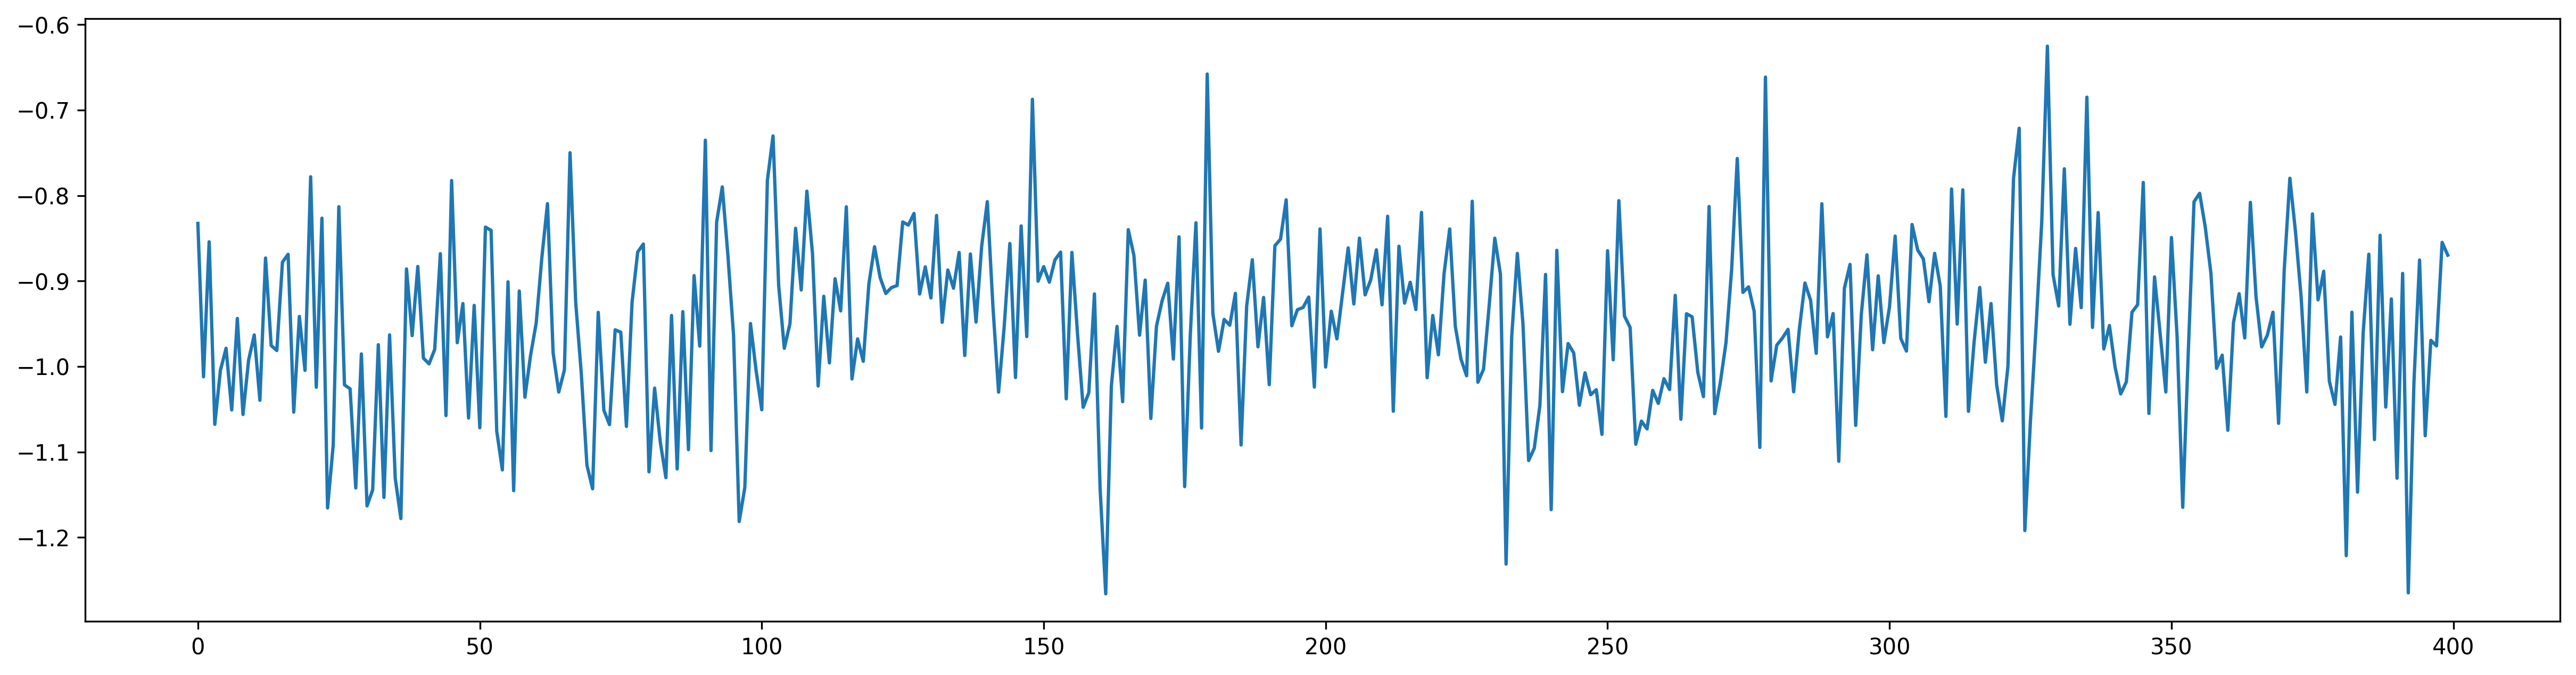

In [29]:
plt.plot(train_ds[5][0][0].squeeze())

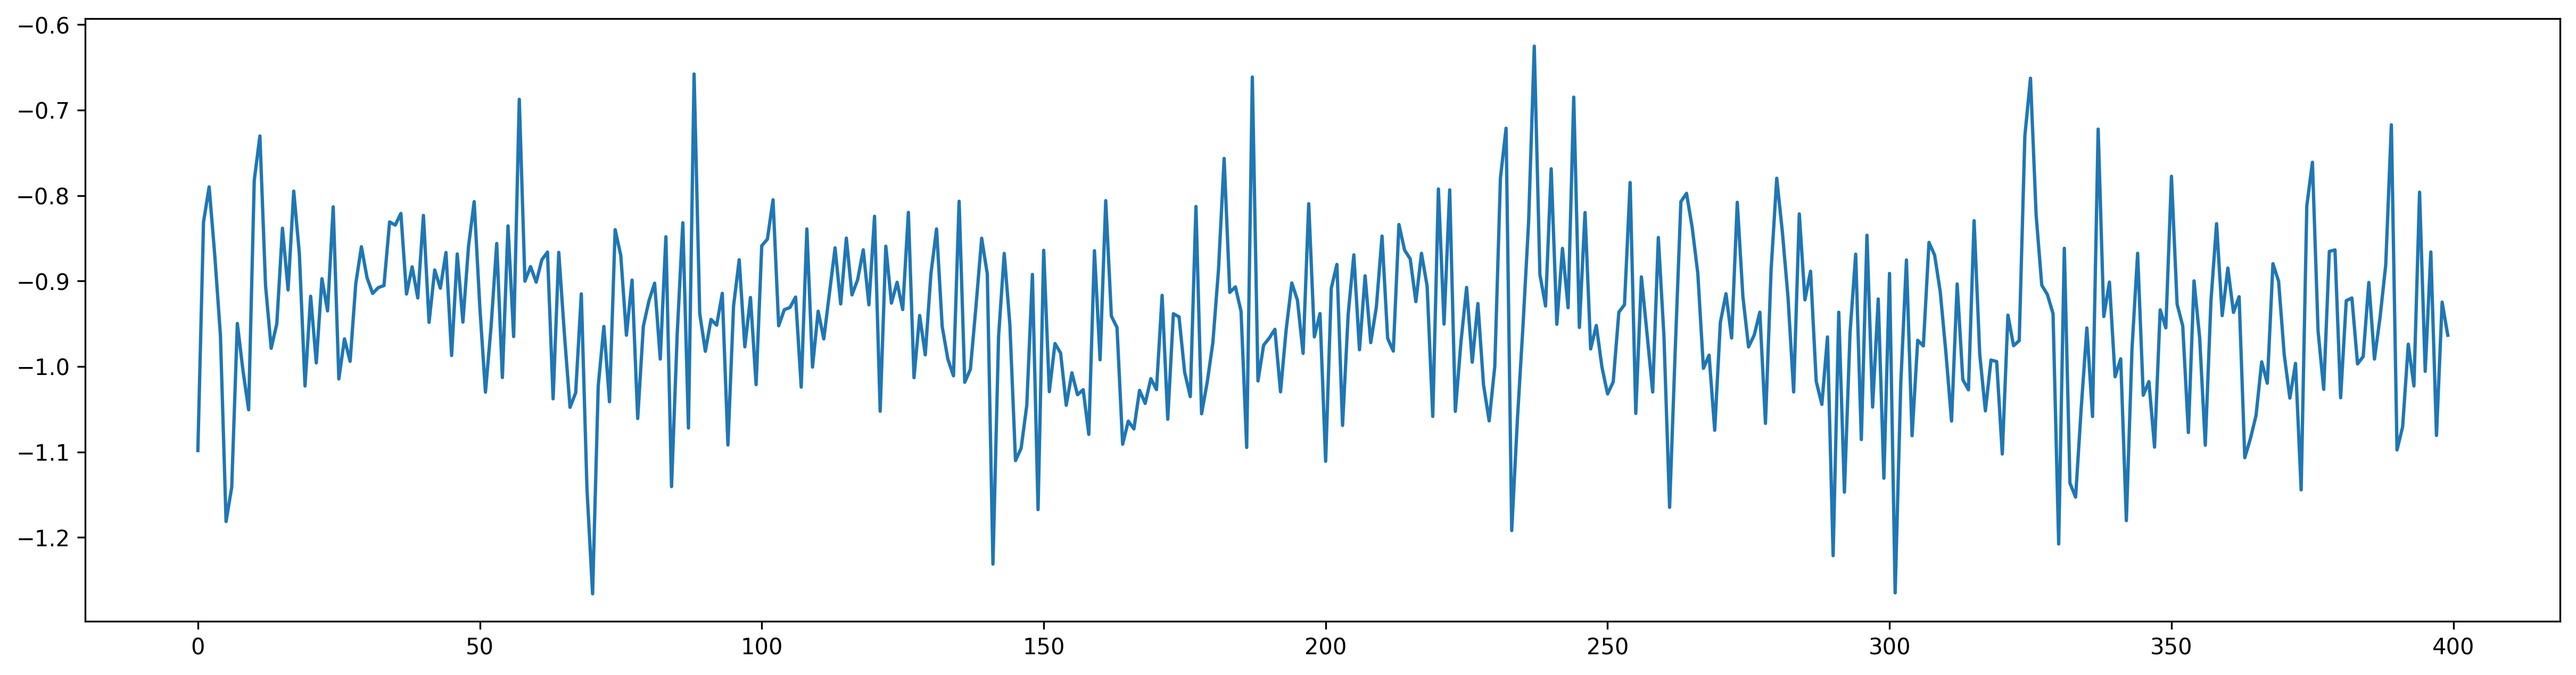

In [30]:
plt.plot(train_ds[5][0][0].squeeze())

In [31]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device())


In [32]:
class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim, _):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device).type(self.inv_freq.type())
        sinusoid_inp = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb[None, :, :]
    
class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        self.emb = nn.Embedding(max_seq_len, dim)
        self.emb.weight.data.uniform_(-0.01, 0.01)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device)
        return self.emb(t)
    
class DummyDecoder(Module):
    def __init__(self,dropout:float=0):
        self.dropout = nn.Dropout(dropout)

    def forward(self,tgt, memory, tgt_mask=None, memory_mask=None, 
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        return self.dropout(memory)

    
class DummyEncoder(Module):
    def __init__(self,dropout:float=0):
        self.dropout = nn.Dropout(dropout)

    def forward(self,src, mask=None, src_key_padding_mask=None):
        return self.dropout(src)

    
class Classiformer(Module):
    def __init__(self, dim, depth, heads, lsh_dropout, bucket_size):
        self.dim = dim
        
        if False:
            self.reformer = Reformer(
                dim = dim,
                depth = depth,
                max_seq_len = WINDOW_SIZE,
                heads = heads,
                lsh_dropout = lsh_dropout,
                bucket_size=bucket_size,
                causal = False
            )
        
        self.transformer = nn.Transformer(
            num_encoder_layers=0,num_decoder_layers=depth,
            nhead=heads,d_model=dim,dim_feedforward=dim*8,dropout=lsh_dropout, 
            custom_encoder=DummyEncoder(dropout=0.))
        
        self.pos_emb = FixedPositionalEmbedding(dim, WINDOW_SIZE)
        self.input_to_dim  = nn.Linear(1, dim)
        self.drift         = nn.Linear(dim, 1)
        self.open_channels = nn.Linear(dim, 11)

    def forward(self, x):
        x,mask_channels = x
        # B 1 S
        w = self.dim//2
        #print(x.shape)
        r = math.ceil(w/WINDOW_SIZE) + 1
        x_lead  = x.repeat(1,1,r)[...,:WINDOW_SIZE+w-1]
        x_lag   = x.repeat(1,1,r).flip((2))[...,:WINDOW_SIZE+w-1]
        lead,lag=x_lead.unfold(2,w,1), x_lag.unfold(2,w,1).flip((2))
        x=torch.cat((lead,lag),dim=3).squeeze(1)#.permute(0,2,1)

        #print(x.shape)
        #x = self.input_to_dim(x.permute(0,2,1))
        
        # B S d
        #x = x + self.pos_emb(x).type(x.type())
        x = x.permute(1,0,2)
        x = self.transformer(x,x) # S,N,E => T,N,E
                                  # S is the source sequence length, 
                                  # T is the target sequence length, 
                                  # N is the batch size, 
                                  # E is the feature number
        x = x.permute(1,0,2)
        drift         = self.drift(x)
        open_channels = self.open_channels(x) #- 1000* (1-mask_channels.unsqueeze(1))
        return drift, open_channels
    

class AtomTorchTransformer(Module):
    def __init__(self,n_layers,n_heads,d_model,d_inner,embed_p:float=0,
                 encoder_dropout:float=0,decoder_dropout:float=0,
                 d_head=None,deep_decoder=False,dense_out=False, **kwargs):
        
        self.d_model = d_model
        d_head = ifnone(d_head, d_model//n_heads)        
        
        

In [33]:
dim = 512
bucket_size = 50
depth = 16
heads = 16
lsh_dropout = 0.

model = ReformerLM(
    num_tokens = 11,
    dim = dim,
    depth = depth,
    max_seq_len = WINDOW_SIZE,
    heads = heads,
    lsh_dropout = lsh_dropout,
    bucket_size=bucket_size,
    causal = False,
    use_full_attn = False,
    fixed_position_emb = False,
    n_hashes = 4,
)
model.token_emb = nn.Linear(1,dim)

In [34]:
model = Classiformer(dim, depth, heads, lsh_dropout, bucket_size)
model

Classiformer(
  (transformer): Transformer(
    (encoder): DummyEncoder(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=4096, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=4096, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=

In [35]:
def tversky_loss(logits, true, alpha, beta, eps=1e-7):
    """Computes the Tversky loss [1].
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        alpha: controls the penalty for false positives.
        beta: controls the penalty for false negatives.
        eps: added to the denominator for numerical stability.
    Returns:
        tversky_loss: the Tversky loss.
    Notes:
        alpha = beta = 0.5 => dice coeff
        alpha = beta = 1 => tanimoto coeff
        alpha + beta = 1 => F beta coeff
    References:
        [1]: https://arxiv.org/abs/1706.05721
    """
    logits = logits.permute(0,2,1).unsqueeze(-1)
    true = true.unsqueeze(-1)
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    fps = torch.sum(probas * (1 - true_1_hot), dims)
    fns = torch.sum((1 - probas) * true_1_hot, dims)
    num = intersection
    denom = intersection + (alpha * fps) + (beta * fns)
    tversky_loss = (num / (denom + eps)).mean()
    return (1 - tversky_loss)

class LabelSmoothingCE(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)
    
class AwareLabelSmoothingCE(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        t_one_hot = torch.zeros(target.shape[0],11,target.shape[2],device=target.device).scatter_(1,target, 1.)
        t_one_hot = t_one_hot.sum(dim=(2,)) > 0. # B C true for classes present in batch
        t_c_per_batch =  t_one_hot.sum(dim=(1,)).float() # B 1 number of classes in each batch
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1) # B C S
        #print(log_preds.shape,t_one_hot.shape,t_c_per_batch.shape)
        #print(log_preds[:2],t_one_hot[:2],t_c_per_batch[:2])
        if self.reduction=='sum': 
            loss = -log_preds.sum()
            assert False
        else:
            loss = (-log_preds*t_one_hot.unsqueeze(-1)/t_c_per_batch.view(-1,1,1)).sum(dim=1) # B C S x B C 1 x B 1 
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

class DriftChannelsLoss(Module):
    def __init__(self):
        self.drift_loss = MSELossFlat()
        self.open_channels_loss_softf1 = partial(tversky_loss, alpha=0.5,beta=0.5) 
        self.open_channels_loss_ce     = LabelSmoothingCE() #CrossEntropyLossFlat() #LabelSmoothingCE()# CrossEntropyLossFlat()
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        i_drift,i_open_channels = input
        t_drift,t_open_channels = target
        return 0.0*self.drift_loss(i_drift, t_drift) + \
            0.*self.open_channels_loss_softf1(i_open_channels, t_open_channels) + \
            1.*self.open_channels_loss_ce(i_open_channels, t_open_channels) 

In [36]:
import sklearn.metrics as skm

# Cell
class OpenChannelsAccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, sigmoid=False, thresh=None, to_np=False, invert_arg=False,
                 flatten=True, **kwargs):
        store_attr(self,'func,dim_argmax,sigmoid,thresh,flatten')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        t,p = learn.y[1],learn.pred[1]
        pred = p.argmax(dim=self.dim_argmax) if self.dim_argmax else p
        if self.sigmoid: pred = torch.sigmoid(pred)
        if self.thresh:  pred = (pred >= self.thresh)
        #pred = p.round()
        targ = t
        pred,targ = to_detach(pred),to_detach(targ)
        if self.flatten: pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__

# Cell
def skm_to__open_channels_fastai(func, is_class=True, thresh=None, axis=-1, sigmoid=None, **kwargs):
    "Convert `func` from sklearn.metrics to a fastai metric"
    dim_argmax = axis if is_class and thresh is None else None
    sigmoid = sigmoid if sigmoid is not None else (is_class and thresh is not None)
    return OpenChannelsAccumMetric(func, dim_argmax=dim_argmax, sigmoid=sigmoid, thresh=thresh,
                       to_np=True, invert_arg=True, **kwargs)

def F1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None):
    "F1 score for single-label classification problems"
    return skm_to__open_channels_fastai(skm.f1_score, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)

def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = inp[1], targ[1]
    pred,targ = flatten_check(pred.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [37]:
learn = None
gc.collect()
torch.cuda.empty_cache()
learn = Learner(dls,model,loss_func=DriftChannelsLoss(),opt_func=Adam,
                metrics=[F1Score(labels=list(range(11)),average='macro'), accuracy])
learn.to_parallel().to_fp16()
learn.summary()

Classiformer (Input shape: ["['36 x 1 x 400', '36 x 11']"])
Layer (type)         Output Shape         Param #    Trainable 
Dropout              36 x 1 x 512         0          False     
________________________________________________________________
Linear               36 x 1 x 4096        2,101,248  True      
________________________________________________________________
Dropout              36 x 1 x 4096        0          False     
________________________________________________________________
Linear               36 x 1 x 512         2,097,664  True      
________________________________________________________________
LayerNorm            36 x 1 x 512         1,024      True      
________________________________________________________________
LayerNorm            36 x 1 x 512         1,024      True      
________________________________________________________________
LayerNorm            36 x 1 x 512         1,024      True      
______________________________________

In [38]:
modelname = None#'ref_512_16_16_50_0.0_36_400_cv0.9380_clean'
try:
    learn.load(modelname)
except:
    pass

In [39]:
#lr_min, lr_steep=learn.lr_find()


In [40]:
learn.fit_one_cycle(30,lr_max=5e-5)#,pct_start=0.3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,1.297693,1.275189,0.368711,0.589232,01:46
1,0.974554,0.893894,0.566559,0.818477,01:41
2,0.689360,0.648117,0.830433,0.945166,01:42
3,0.649695,0.626154,0.903339,0.951265,01:42
4,0.618710,0.614084,0.901402,0.953299,01:42
5,0.613501,0.597081,0.927196,0.961720,01:42
6,0.606739,0.600237,0.915675,0.959558,01:42
7,0.600619,0.613579,0.897842,0.952437,01:42
8,0.596509,0.593430,0.927426,0.962463,01:42
9,0.594260,0.592256,0.921064,0.962540,01:42


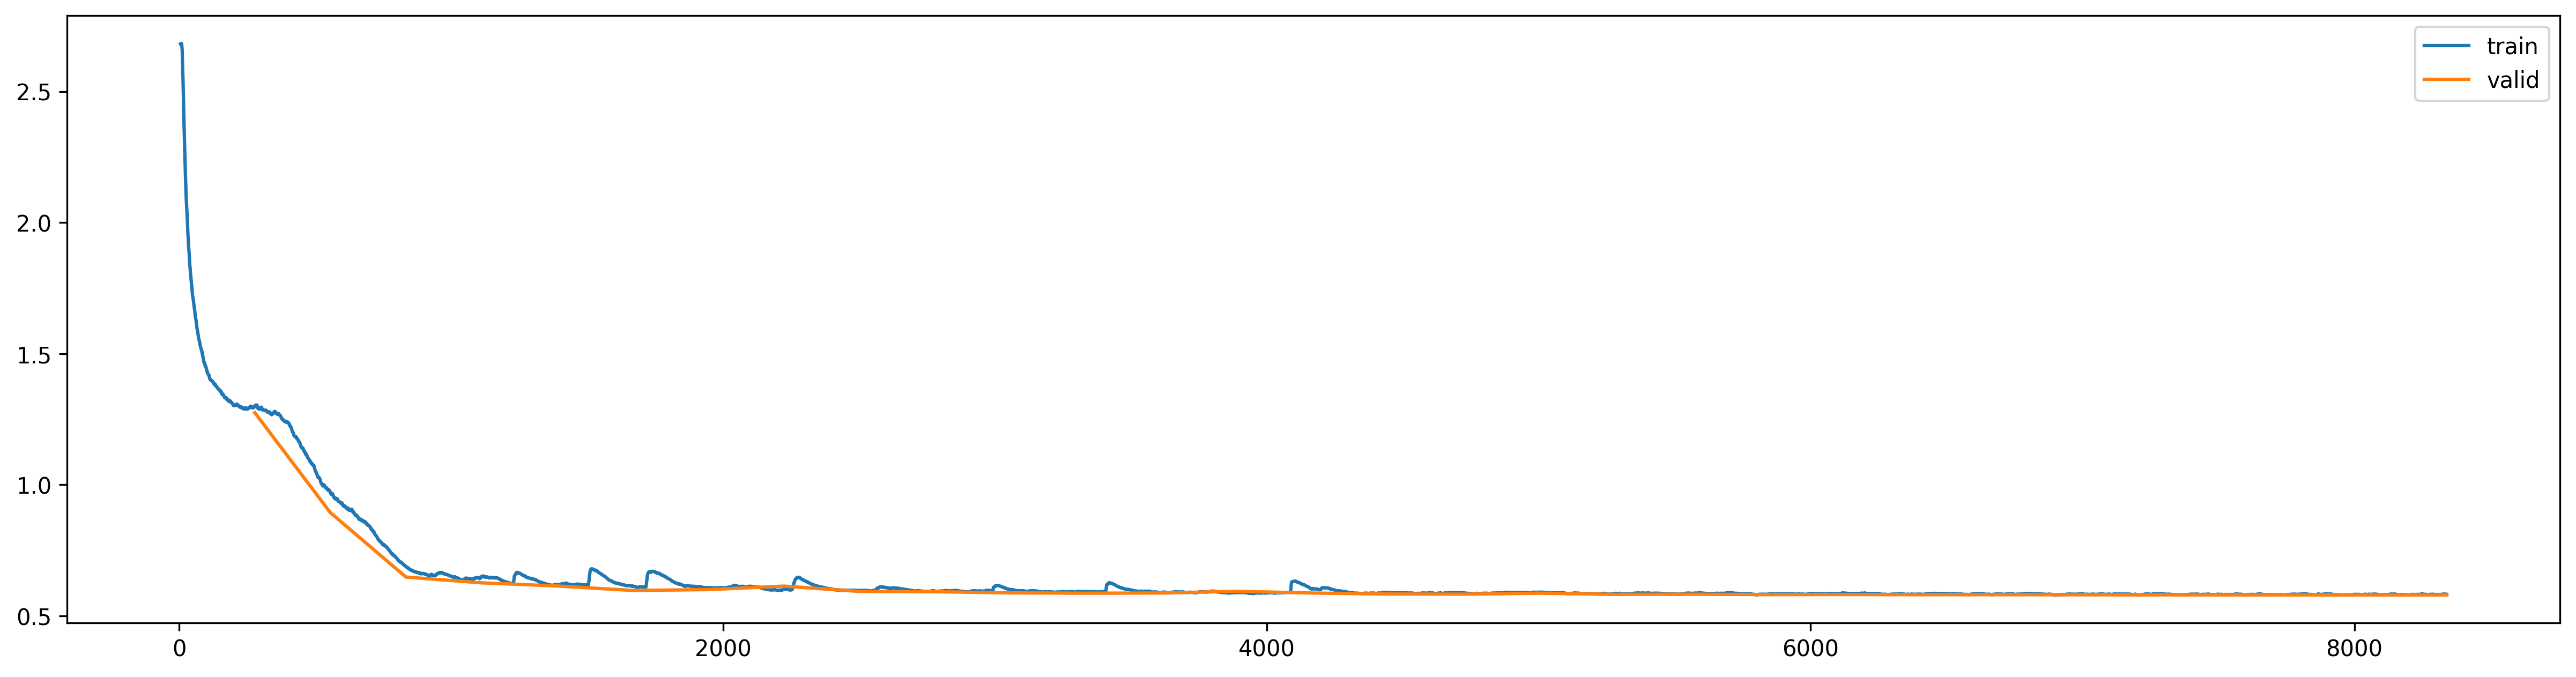

In [41]:
learn.recorder.plot_loss()

In [42]:
cv,_,time = learn.recorder.log[-3:];cv,_,time

(0.9373417766950168, 0.9682098627090454, '01:42')

In [43]:
modelname = f'ref_{dim}_{depth}_{heads}_{bucket_size}_{lsh_dropout}_{BS}_{WINDOW_SIZE}_cv{cv:0.04f}{DATA_SUFFIX}'
learn.save(modelname);modelname

'ref_512_16_16_50_0.0_36_400_cv0.9373_clean'

In [53]:
learn.model.eval()
test_preds = torch.zeros(test[0].numel(),11,dtype=torch.float)
n_tta = 0
with torch.no_grad():
    for flip in [False, True]:
        for i,xx in enumerate(progress_bar(test_dl)):
            x = xx[0]
            if flip: x[0] = torch.flip(x[0], dims=(2,))#x[0].device)
            x = x[0].to(device=default_device()), x[1].to(device=default_device())
            preds = learn.model(x)
            open_channels = preds[1] #- 1000 * (1 - x[1].unsqueeze(1))
            #if i *WINDOW_SIZE*BS > SEGMENT_SIZE*2: print(x[1])
            if flip: open_channels = torch.flip(open_channels, dims=(1,))
            test_preds[i*WINDOW_SIZE*BS:(i+1)*WINDOW_SIZE*BS] += open_channels.view(-1,11).cpu()
        n_tta +=1

In [54]:
test_preds

tensor([[ 8.1227, -1.1089, -1.0906,  ..., -1.0820, -1.0766, -1.0839],
        [ 8.1272, -1.0887, -1.0894,  ..., -1.0810, -1.0717, -1.0792],
        [ 8.1276, -1.0872, -1.0892,  ..., -1.0808, -1.0710, -1.0787],
        ...,
        [ 8.1357, -1.0605, -1.0773,  ..., -1.0752, -1.0731, -1.0707],
        [ 8.1369, -1.0568, -1.0763,  ..., -1.0747, -1.0715, -1.0696],
        [ 8.1349, -1.0645, -1.0770,  ..., -1.0755, -1.0740, -1.0716]])

In [55]:
open_channels = test_preds.argmax(dim=1)
open_channels.shape

torch.Size([2000000])

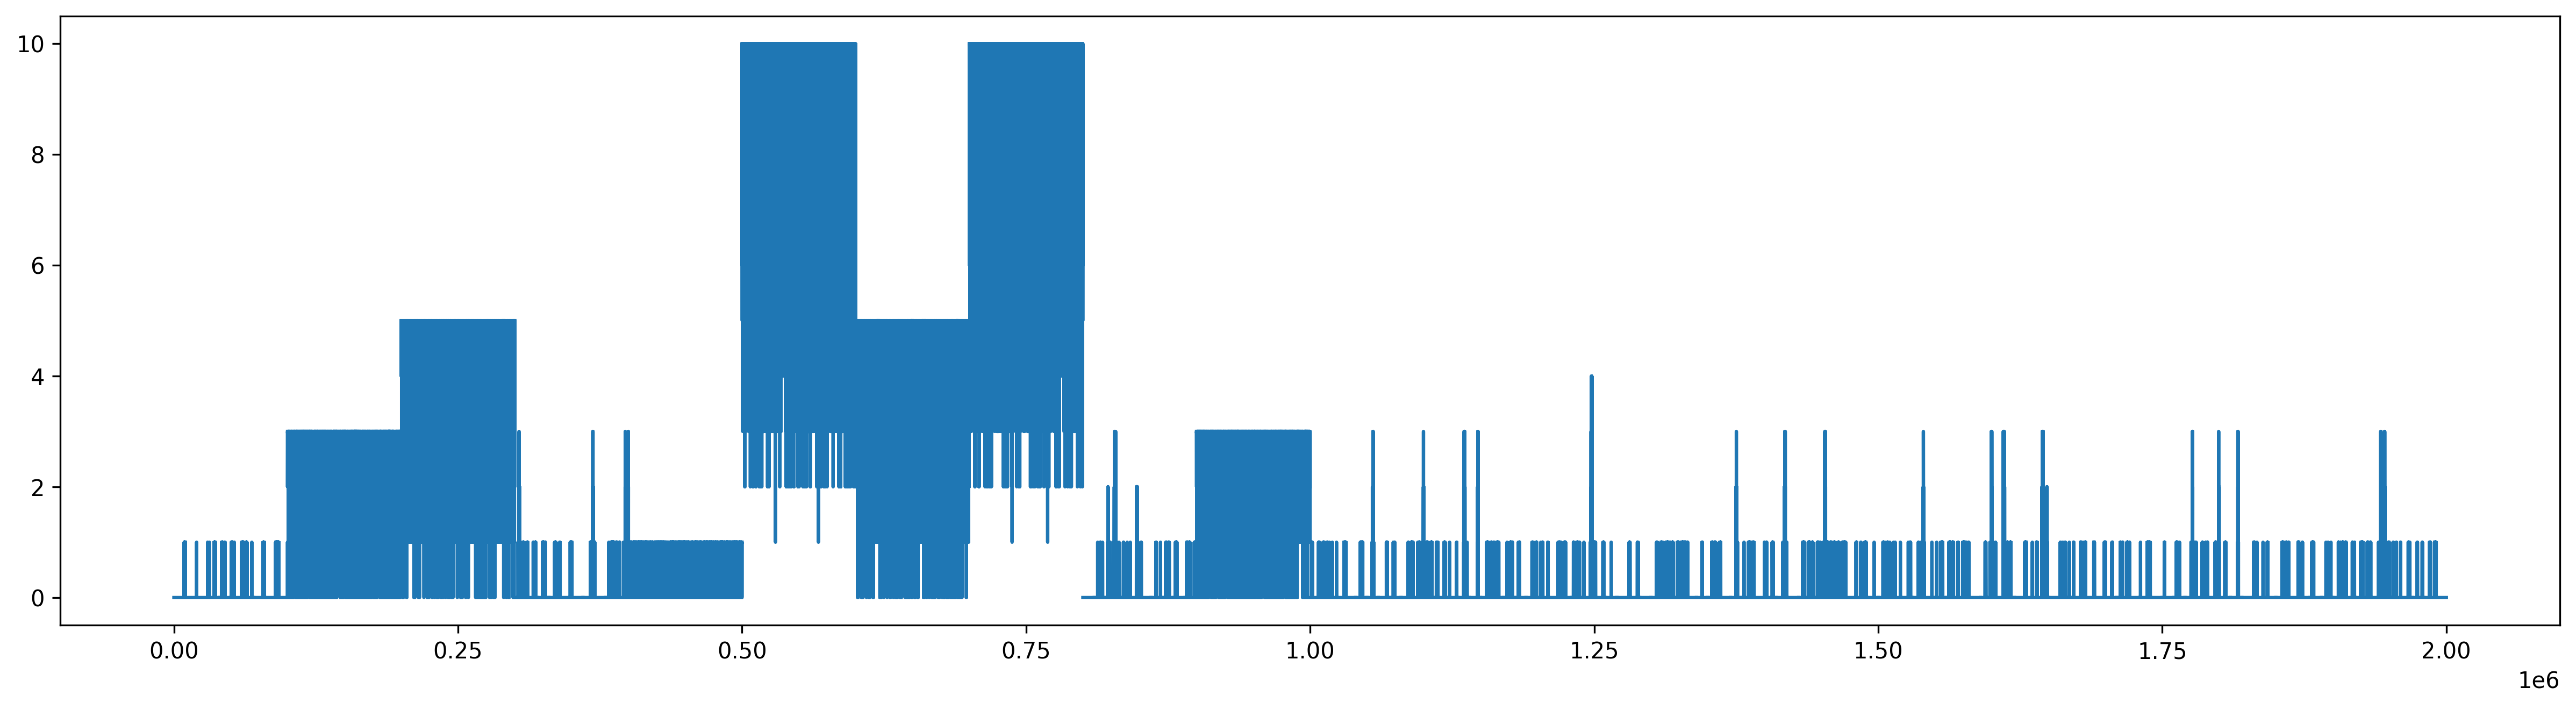

In [56]:
plt.plot(open_channels)

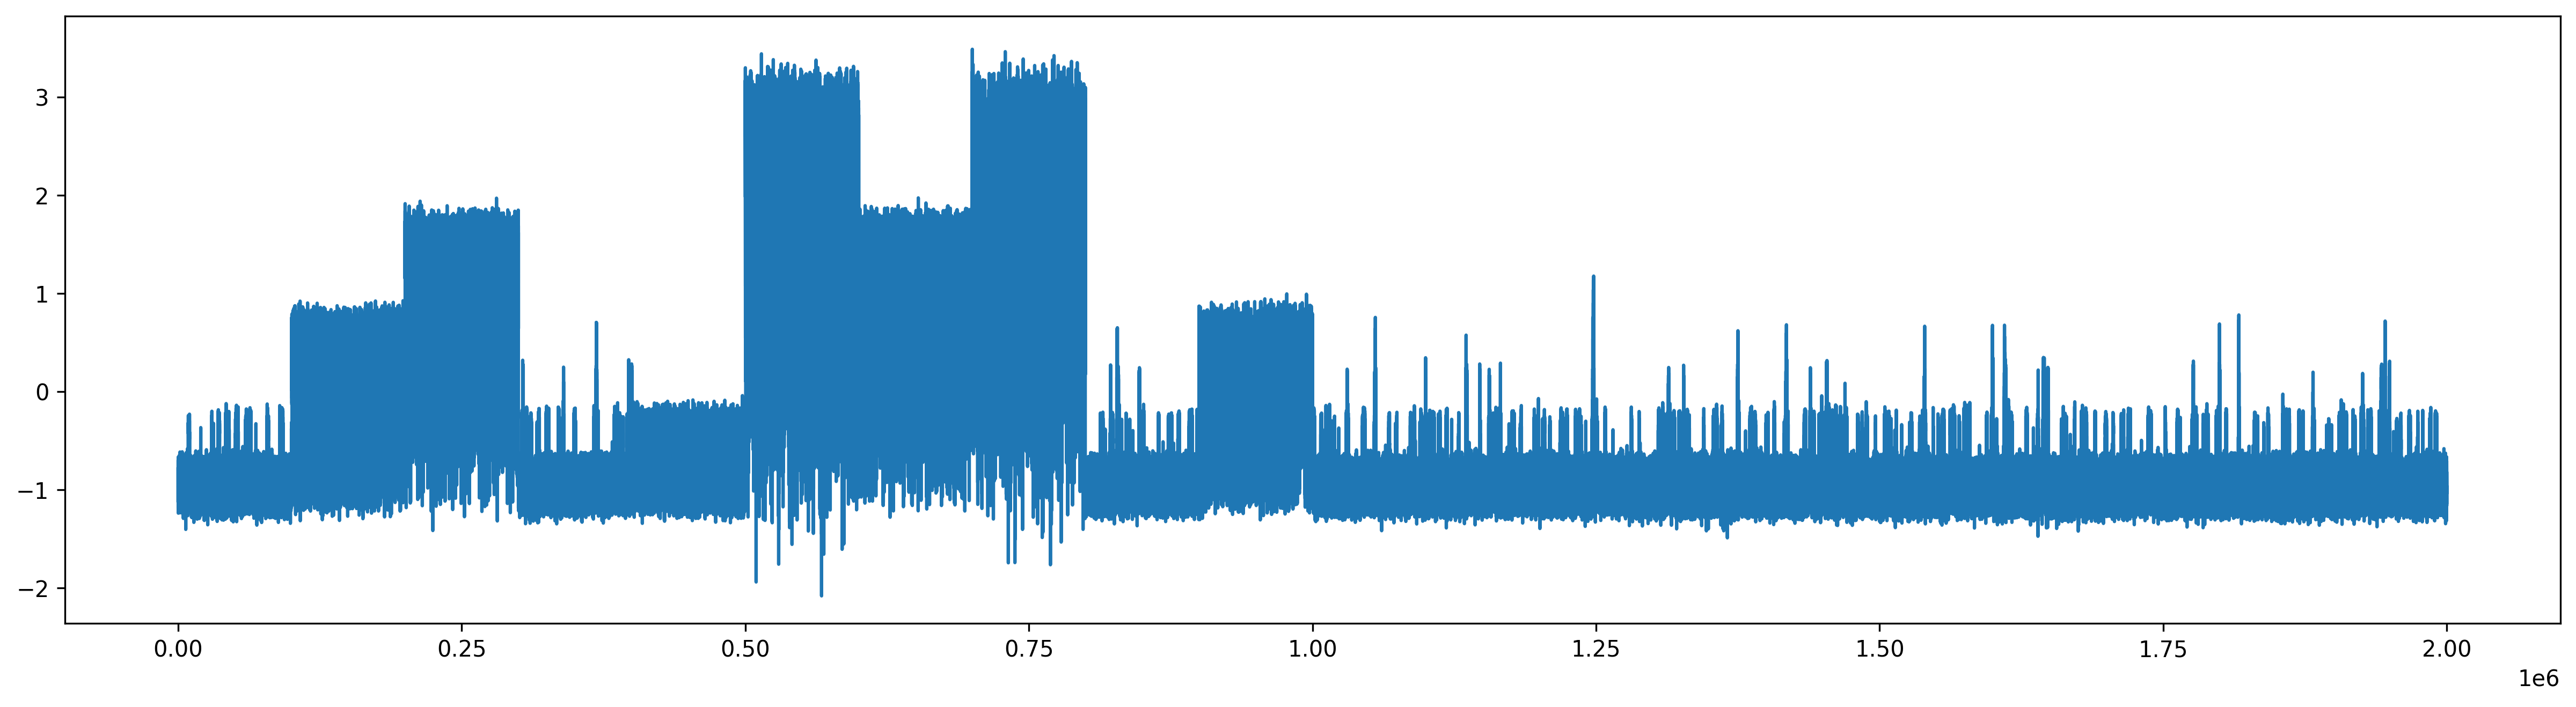

In [57]:
plt.plot(test[0].flatten())

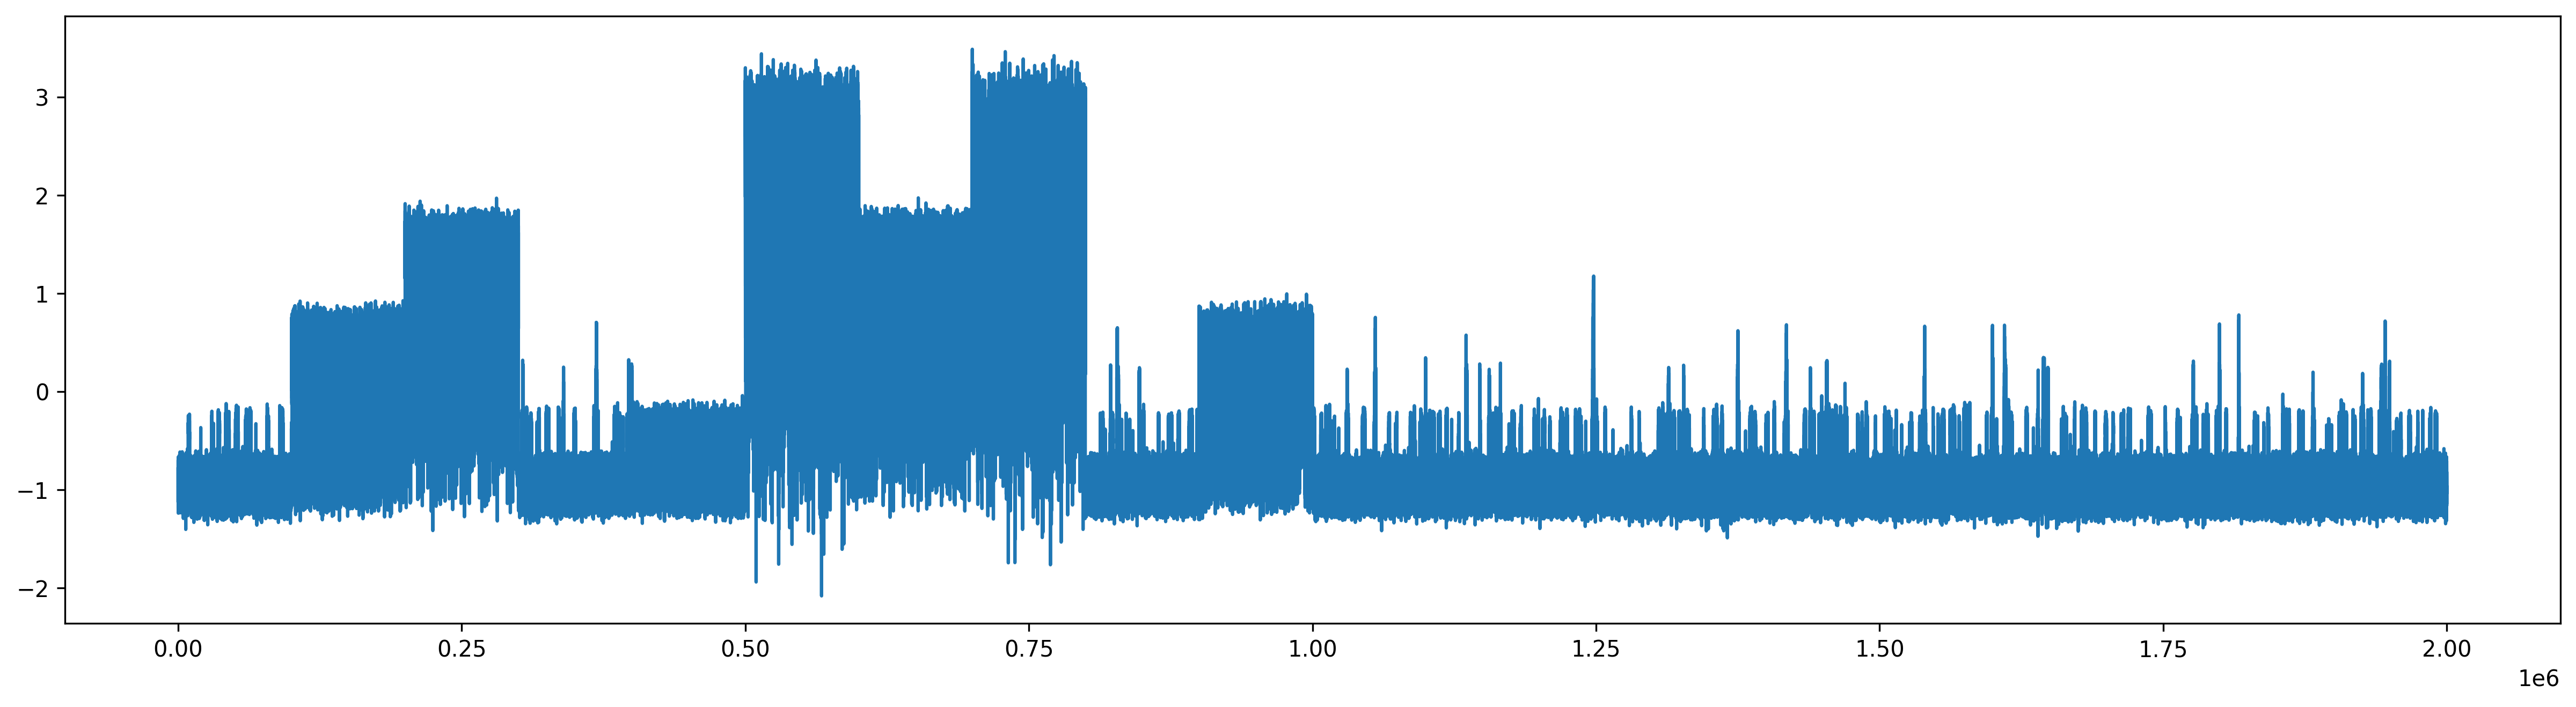

In [58]:
plt.plot(test[0].flatten())

In [68]:
csv_fname = f'{modelname}_n_tta{n_tta}.csv';csv_fname

'ref_512_16_16_50_0.0_36_400_cv0.9373_clean_n_tta2.csv'

In [69]:
submission_csv_path = p_input / 'sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str), 'open_channels': open_channels})
test_pred_frame.to_csv(csv_fname, index=False)

In [70]:
!kaggle competitions submit -c 'liverpool-ion-switching' -f {csv_fname} -m 'trans 1 feat lag/lead jitter flip=0.5 10 epochs '

100%|██████████████████████████████████████| 21.0M/21.0M [00:05<00:00, 4.07MB/s]
Successfully submitted to University of Liverpool - Ion Switching